In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import ptitprince as pt
import pickle as pkl
from src.data.analyse import *
from tqdm import tqdm
from ema_workbench import load_results
sns.set_theme(style="ticks")

## Load results

In [5]:
# Load results
n_scenarios = 1000
n_policies = 0
results = load_results(f'../results/scenarios={n_scenarios}, policies={n_policies}.tar.gz')

# Prepare outcomes
outcomes = prepare_outcomes(results, add_policies=False)

In [6]:
numeric_columns = outcomes.columns[3:-1].tolist()
columns_of_interest = ['total_asset_loss', 
                       'total_consumption_loss', 
                       'n_affected_people',
                       'n_new_poor',
                       'new_poverty_gap',
                       'annual_average_consumption_loss',
                       'annual_average_consumption_loss_pct',
                       'r']

outcomes[numeric_columns] = outcomes[numeric_columns].apply(pd.to_numeric)

In [7]:
# Rename district column
# outcomes = outcomes.rename(columns={'district': 'District'})
outcomes['district'].replace({'AnseLaRayeCanaries': 'Anse-La-Raye & Canaries'}, inplace=True)

# Convert Annual average consumption loss to percentage
outcomes['annual_average_consumption_loss_pct'] = outcomes['annual_average_consumption_loss_pct'] * 100
outcomes['initial_poverty_gap'] = outcomes['initial_poverty_gap'] * 100
outcomes['new_poverty_gap'] = outcomes['new_poverty_gap'] * 100

## Verification & EDA

To be verified:
- `n_new_poor` V
- `n_new_poor_pct` V
- `new_poverty_gap` V
- `annual_average_consumption_loss_pct` V
- `r` V
- `years_in_poverty` X 

In [8]:
scenario = 0
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)
# df = df[list(d.keys())].round(2)
# df.columns = list(d.values())
# df.index.name = 'District'
df[numeric_columns].round(2).style.format("{:,.2f}")

,total_population,total_asset_loss,total_consumption_loss,event_damage,total_asset_stock,average_productivity,total_asset_in_survey,expected_loss_fraction,n_affected_people,annual_average_consumption,poverty_line_adjusted,pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap,annual_average_consumption_loss,annual_average_consumption_loss_pct,r,recovery_rate
district,,,,,,,,,,,,,,,,,,,,,
Anse-La-Raye & Canaries,"8,666.91","1,254,208.66","1,106,581.11","1,282,936.18","47,442,177.05",0.48,"334,331,195.84",0.03,771.34,"1,591.22",914.27,"1,282,936.18","3,292.00",181.00,0.00,32.85,32.85,143.46,9.39,1.16,0.48
Castries,"70,959.09","31,203,800.98","47,746,301.96","31,062,668.40","1,587,405,663.34",0.30,"3,435,721,049.12",0.02,"2,279.02","6,213.45","2,976.86","31,062,668.40","15,948.00",496.00,53.00,34.78,34.78,"2,095.03",26.45,0.65,0.31
Choiseul,"5,475.87","1,092,909.95","1,784,373.27","1,111,847.84","54,354,802.37",0.19,"377,890,219.98",0.02,430.57,"1,932.86",926.75,"1,111,847.84",923.00,181.00,23.00,26.55,25.98,414.42,22.64,0.62,0.23
Dennery,"11,590.78","2,656,235.30","6,383,111.11","2,667,414.34","125,372,604.01",0.56,"417,528,403.13",0.02,966.05,"3,383.57","1,934.66","2,667,414.34","5,216.00",666.00,0.00,23.52,23.52,660.74,23.89,0.42,0.33
Gros Islet,"27,467.06","11,098,629.71","15,081,182.83","10,932,607.53","532,061,766.39",0.28,"3,294,339,146.51",0.02,"1,061.17","2,841.95","1,040.60","10,932,607.53","3,245.00",0.00,224.00,15.39,17.04,"1,421.18",34.95,0.72,0.31
Laborie,"6,828.32","1,997,825.23","3,885,061.31","2,035,118.22","99,235,698.32",0.35,"215,695,044.06",0.02,285.17,"5,123.26","2,964.26","2,035,118.22","1,599.00",112.00,173.00,23.26,23.67,"1,362.34",41.00,0.52,0.30
Micoud,"17,435.51","4,879,756.22","5,905,267.52","4,766,541.74","231,995,156.10",0.32,"554,020,360.02",0.02,761.85,"6,056.25","2,698.00","4,766,541.74","5,433.00",347.00,130.00,38.18,37.78,775.12,14.50,0.81,0.24
Soufriere,"8,985.05","1,688,097.96","2,547,724.41","1,679,254.31","82,756,712.06",0.23,"535,928,432.44",0.02,580.91,"2,953.40",994.91,"1,679,254.31","2,295.00",150.00,0.00,31.47,31.47,438.58,25.21,0.66,0.15
Vieuxfort,"15,229.37","4,346,190.28","4,726,085.35","4,264,030.49","216,534,648.76",0.32,"1,266,550,258.12",0.02,757.91,"2,121.05","1,101.52","4,264,030.49","5,272.00",386.00,64.00,23.35,23.73,623.57,39.31,0.90,0.23


In [35]:
# Let's look at a single scenario
scenario = 4
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)

# Let's take Anse-La-Raye & Canaries as an example
district = 'Anse-La-Raye & Canaries'
district = 'Choiseul'
total_population = round(df.loc[district, 'total_population'])
n_affected = round(df.loc[district, 'n_affected_people'])
print('Total population: ', total_population)
print('Number of affected people: ', n_affected)

n_poor_initial = round(df.loc[district, 'n_poor_initial'])
n_new_poor = round(df.loc[district, 'n_new_poor'])
pct_poor_initial = round(n_poor_initial / total_population * 100, 2)
pct_new_poor = round((n_new_poor + n_poor_initial) / total_population * 100, 2)
pct_poor_increase = round(n_new_poor / total_population * 100, 2)
initial_poverty_gap = round(df.loc[district, 'initial_poverty_gap'], 2)
new_poverty_gap = round(df.loc[district, 'new_poverty_gap'], 2)
print()
print('Number of poor: ', n_poor_initial)
print('Number of new poor: ', n_new_poor)
print(f'Percentage of poor: {pct_poor_initial}%')
print(f'Percentage of new poor: {pct_new_poor}%')
print(f'Percentage of increase in poor: {pct_poor_increase}%')
print('Initial poverty gap: ', initial_poverty_gap)
print('New poverty gap: ', new_poverty_gap)

annual_average_consumption = round(df.loc[district, 'annual_average_consumption'])
annual_average_consumption_loss = round(df.loc[district, 'annual_average_consumption_loss'])
annual_average_consumption_loss_pct = round(df.loc[district, 'annual_average_consumption_loss_pct'])
print()

print('Annual average consumption: ', annual_average_consumption)
print('Annual average consumption loss: ', annual_average_consumption_loss)
print(f'Annual average consumption loss percentage: {annual_average_consumption_loss_pct}%')

print()
r = round(df.loc[district, 'r'], 2)
print('Socio-economic resilience: ', r)

Total population:  5476
Number of affected people:  114

Number of poor:  923
Number of new poor:  22
Percentage of poor: 16.86%
Percentage of new poor: 17.26%
Percentage of increase in poor: 0.4%
Initial poverty gap:  26.55
New poverty gap:  26.8

Annual average consumption:  1933
Annual average consumption loss:  912
Annual average consumption loss percentage: 33%

Socio-economic resilience:  1.07


In [18]:
columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '>10']
index = ['Anse-La-Raye & Canaries', 'Castries', 'Choiseul', 'Dennery', 'Gros Islet', 'Laborie', 'Micoud', 'Soufriere', 'Vieuxfort']
average_years_in_poverty = pd.DataFrame(columns=columns, index=index)
average_years_in_poverty = average_years_in_poverty.fillna(0)
n_scenarios = outcomes['scenario'].unique().size
for scenario in tqdm(outcomes['scenario'].unique()):
    df = outcomes[outcomes['scenario'] == scenario]
    df.set_index('district', inplace=True)
    years_in_poverty = pd.DataFrame(columns=columns)
    for index, row in df.iterrows():
        x = row['years_in_poverty']
        for key, values in x.items():
            if key == 10:
                key_value = ">10"
            else:
                key_value = str(key)
            years_in_poverty.loc[index, key_value] = int(values)
    average_years_in_poverty += years_in_poverty
average_years_in_poverty = average_years_in_poverty / n_scenarios
average_years_in_poverty

100%|██████████| 1000/1000 [00:29<00:00, 33.98it/s]


,0,1,2,3,4,5,6,7,8,9,>10
Anse-La-Raye & Canaries,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.828
Castries,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.932,6.169,542.82
Choiseul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.303
Dennery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.374
Gros Islet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.808
Laborie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161,49.576
Micoud,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026,77.908
Soufriere,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.096
Vieuxfort,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,259.043


In [19]:
outcomes[['district', 'n_new_poor']].groupby(['district']).mean()['n_new_poor']

district
Anse-La-Raye & Canaries     73.828
Castries                   549.926
Choiseul                    76.303
Dennery                     59.374
Gros Islet                 198.808
Laborie                     49.736
Micoud                      77.934
Soufriere                  105.096
Vieuxfort                  259.043
Name: n_new_poor, dtype: float64

In [20]:
# Print df with comma separator for thousands with 2 decimals
outcomes.iloc[:, 2:-1].groupby('district').median(numeric_only=True).round(2).style.format("{:,.2f}")

,total_population,total_asset_loss,total_consumption_loss,event_damage,total_asset_stock,average_productivity,total_asset_in_survey,expected_loss_fraction,n_affected_people,annual_average_consumption,poverty_line_adjusted,pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap,annual_average_consumption_loss,annual_average_consumption_loss_pct,r,recovery_rate
district,,,,,,,,,,,,,,,,,,,,,
Anse-La-Raye & Canaries,"8,666.91","1,280,316.90","2,057,587.82","1,282,936.18","47,442,177.05",0.48,"334,331,195.84",0.03,624.94,"1,591.22",914.27,"1,282,936.18","3,292.00",189.00,64.00,32.85,32.85,320.62,19.72,0.62,0.42
Castries,"70,959.09","31,055,096.64","46,628,671.31","31,062,668.40","1,587,405,663.34",0.30,"3,435,721,049.12",0.02,"3,041.75","6,213.45","2,976.86","31,062,668.40","15,948.00",595.50,501.00,34.78,34.55,"1,508.87",24.89,0.67,0.26
Choiseul,"5,475.87","1,109,987.05","1,649,237.58","1,111,847.84","54,354,802.37",0.19,"377,890,219.98",0.02,260.06,"1,932.86",926.75,"1,111,847.84",923.00,0.00,69.00,26.55,26.55,625.30,32.58,0.67,0.20
Dennery,"11,590.78","2,666,272.20","3,934,483.83","2,667,414.34","125,372,604.01",0.56,"417,528,403.13",0.02,588.42,"3,383.57","1,934.66","2,667,414.34","5,216.00",244.00,0.00,23.52,23.52,653.46,20.95,0.68,0.52
Gros Islet,"27,467.06","10,918,635.80","13,912,903.85","10,932,607.53","532,061,766.39",0.28,"3,294,339,146.51",0.02,"1,460.36","2,841.95","1,040.60","10,932,607.53","3,245.00",38.00,179.00,15.39,15.39,977.91,29.63,0.79,0.24
Laborie,"6,828.32","2,034,778.18","3,625,432.73","2,035,118.22","99,235,698.32",0.35,"215,695,044.06",0.02,311.50,"5,123.26","2,964.26","2,035,118.22","1,599.00",45.00,23.00,23.26,23.26,"1,189.61",23.22,0.56,0.32
Micoud,"17,435.51","4,764,118.56","7,819,493.29","4,766,541.74","231,995,156.10",0.32,"554,020,360.02",0.02,814.27,"6,056.25","2,698.00","4,766,541.74","5,433.00",198.00,36.00,38.18,38.18,947.13,17.17,0.61,0.29
Soufriere,"8,985.05","1,678,683.61","2,616,049.71","1,679,254.31","82,756,712.06",0.23,"535,928,432.44",0.02,429.96,"2,953.40",994.91,"1,679,254.31","2,295.00",59.00,93.00,31.47,31.47,600.46,28.87,0.64,0.17
Vieuxfort,"15,229.37","4,253,568.91","6,630,778.52","4,264,030.49","216,534,648.76",0.32,"1,266,550,258.12",0.02,"1,043.35","2,121.05","1,101.52","4,264,030.49","5,272.00",311.00,209.50,23.35,23.40,633.33,30.40,0.64,0.28


A pairplot can show relations between pairs of variables and their distributions. We can visualise a single district or all of them at once.

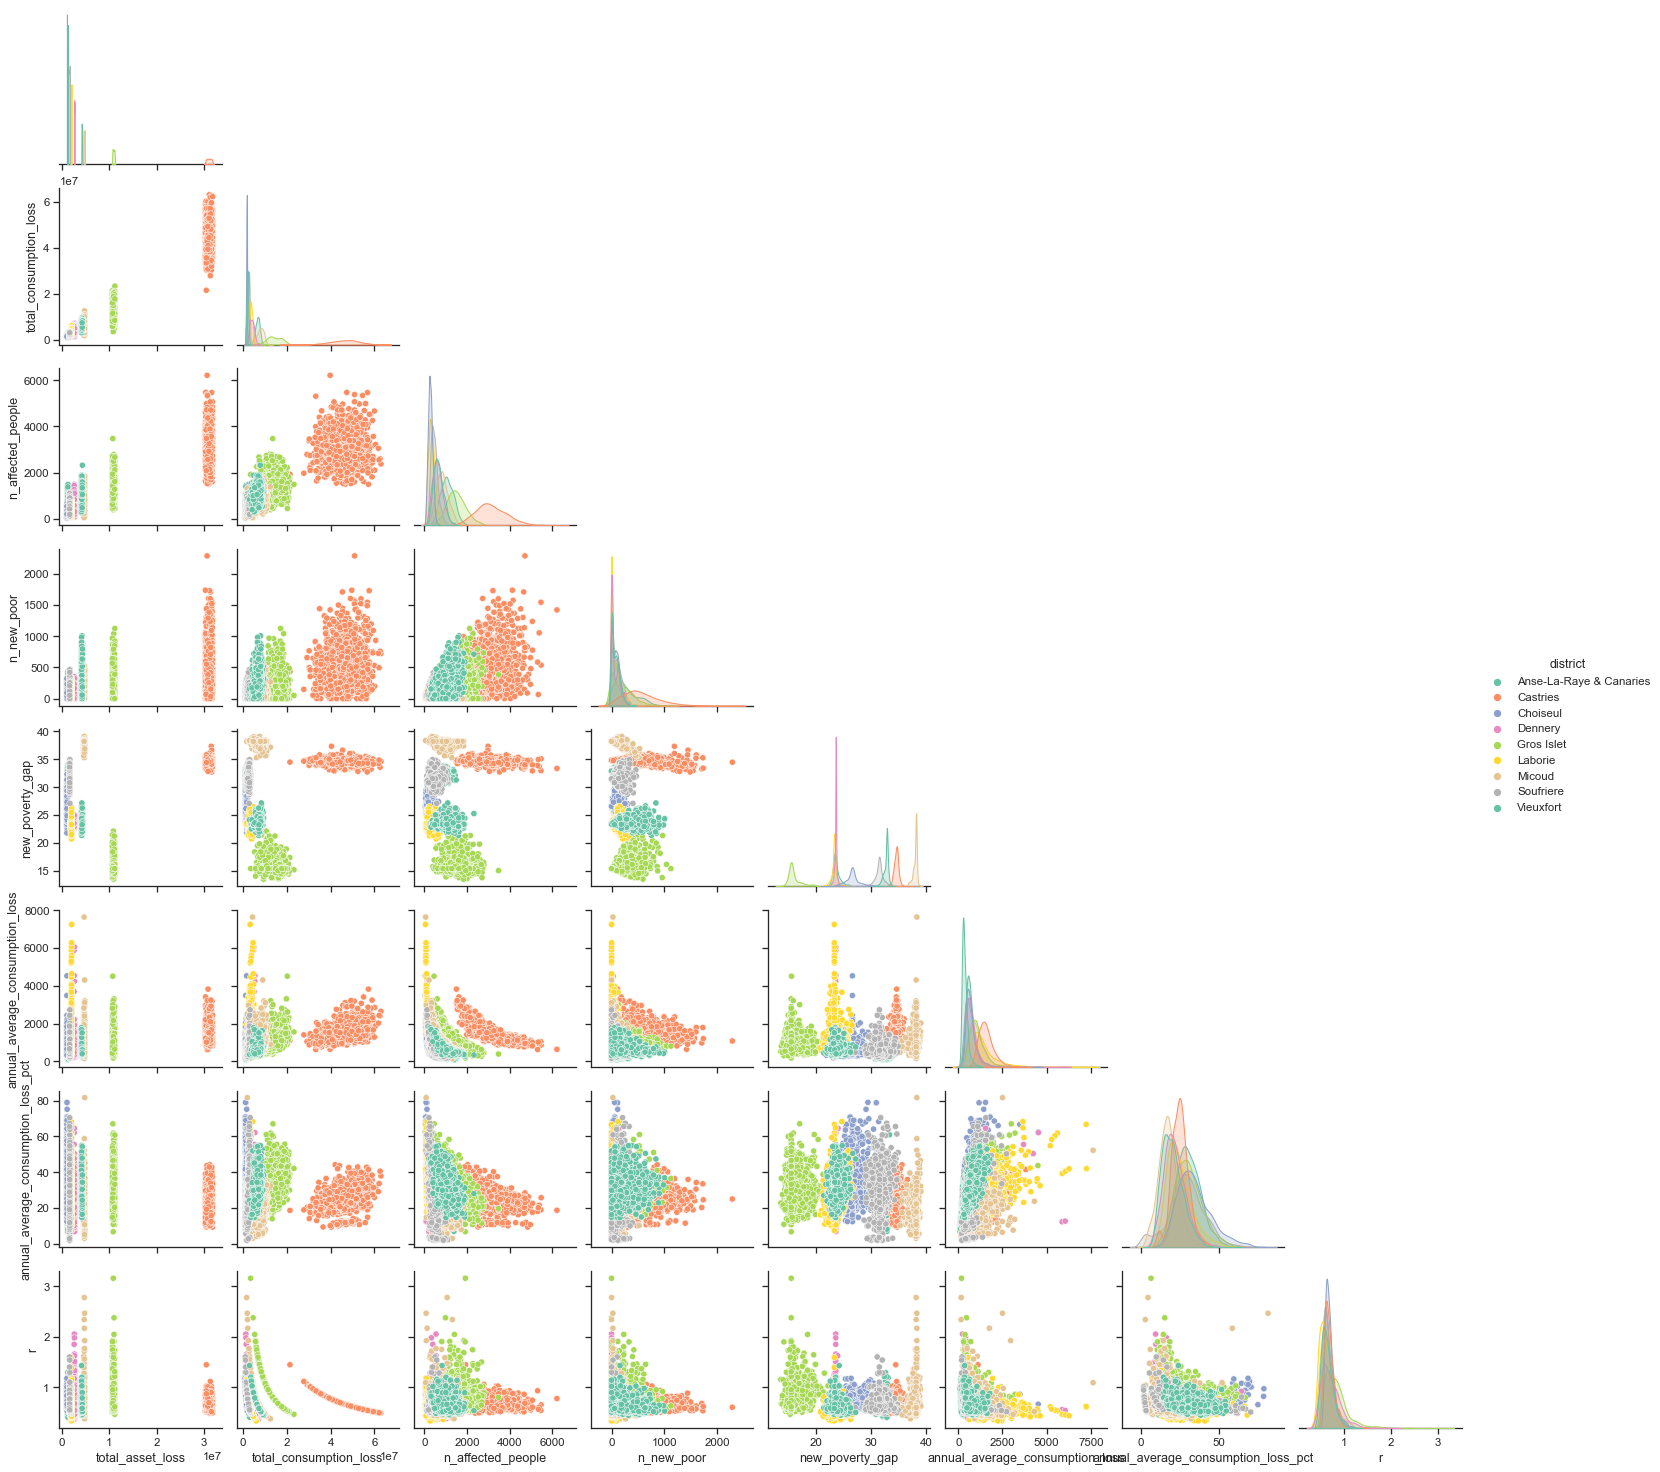

In [22]:
df = outcomes[['district'] + columns_of_interest]
sns.pairplot(df, hue='district', palette='Set2', corner=True);

Now let's examine individual outcomes and their relations.

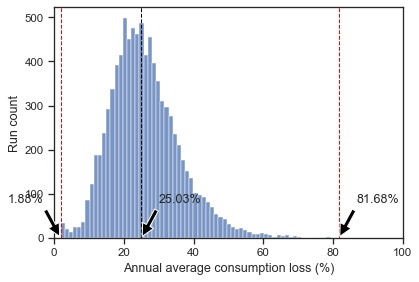

In [23]:
sns.histplot(outcomes['annual_average_consumption_loss_pct'])
plt.xlabel('Annual average consumption loss (%)')
plt.ylabel('Run count')
plt.xlim(0, 100);
plt.savefig('../figures/analysis/annual_average_consumption_loss_pct.png')
# Add min and max values
plt.axvline(outcomes['annual_average_consumption_loss_pct'].min(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(outcomes['annual_average_consumption_loss_pct'].max(), color='red', linestyle='dashed', linewidth=1)
# Add median value
plt.axvline(outcomes['annual_average_consumption_loss_pct'].median(), color='black', linestyle='dashed', linewidth=1)
# Annotate min and max values
plt.annotate(f"{outcomes['annual_average_consumption_loss_pct'].min():.2f}%",
                xy=(outcomes['annual_average_consumption_loss_pct'].min(), 0),
                xytext=(outcomes['annual_average_consumption_loss_pct'].min() - 5, 100),
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='top')
plt.annotate(f"{outcomes['annual_average_consumption_loss_pct'].max():.2f}%",
                xy=(outcomes['annual_average_consumption_loss_pct'].max(), 0),
                xytext=(outcomes['annual_average_consumption_loss_pct'].max() + 5, 100),
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left', verticalalignment='top')
# Annotate median value
plt.annotate(f"{outcomes['annual_average_consumption_loss_pct'].median():.2f}%",
                xy=(outcomes['annual_average_consumption_loss_pct'].median(), 0),
                xytext=(outcomes['annual_average_consumption_loss_pct'].median() + 5, 100),
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left', verticalalignment='top');
# plt.savefig('../figures/analysis/annual_average_consumption_loss_pct_with_min_max.png')

In [24]:
outcomes['annual_average_consumption_loss_pct'].describe()

count    9000.000000
mean       26.173124
std        10.042343
min         1.876670
25%        19.281576
50%        25.025352
75%        31.782758
max        81.682878
Name: annual_average_consumption_loss_pct, dtype: float64

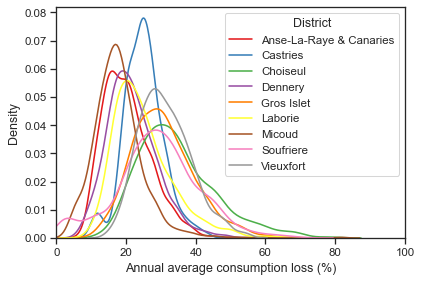

In [25]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots()
colors = sns.color_palette('Set1', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    color = colors[districts.index(district)]
    # sns.histplot(data=df, x='annual_average_consumption_loss_pct', ax=ax, color=color, multiple='stack')
    sns.kdeplot(data=df, x='annual_average_consumption_loss_pct', ax=ax, color=color)
    ax.set_xlabel('Annual average consumption loss (%)')
ax.set_xlim(0, 100)
ax.legend(districts, title='District');

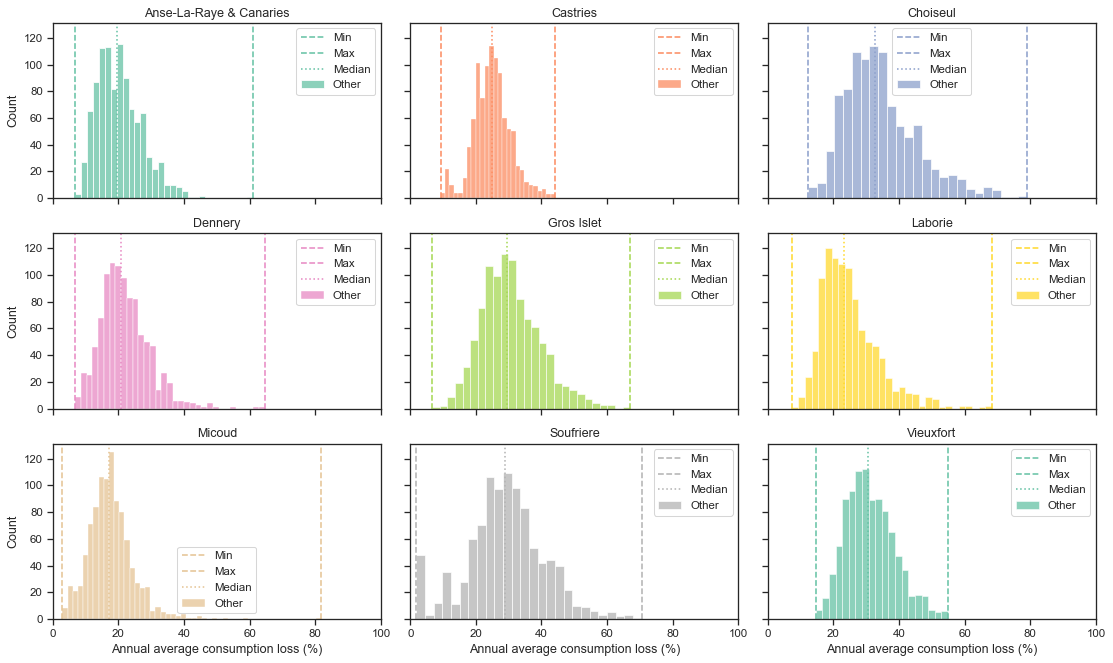

In [26]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    sns.histplot(data=df, x='annual_average_consumption_loss_pct', ax=ax[i, j], multiple='stack', color=color)
    ax[i, j].set_title(district)
    ax[i, j].set_xlabel('Annual average consumption loss (%)')
    ax[i, j].set_xlim(0, 100)
    # Add min and max lines
    ax[i, j].axvline(df['annual_average_consumption_loss_pct'].min(), color=color, linestyle='--')
    ax[i, j].axvline(df['annual_average_consumption_loss_pct'].max(), color=color, linestyle='--')
    # Add median line
    ax[i, j].axvline(df['annual_average_consumption_loss_pct'].median(), color=color, linestyle=':')
    # Add legend
    ax[i, j].legend(['Min', 'Max', 'Median', 'Other'])
fig.tight_layout()

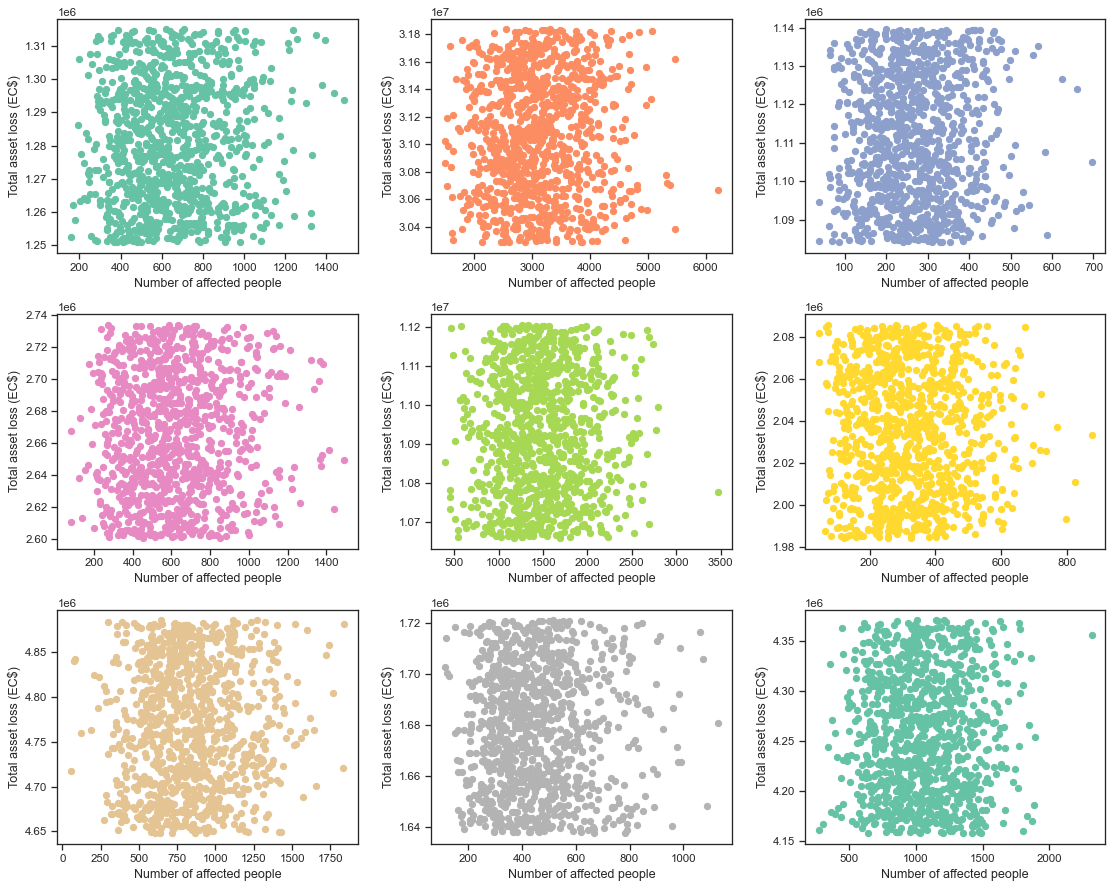

In [37]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 4 * n_districts / 3), sharex=False, sharey=False)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    x = df['n_affected_people']
    y = df['total_asset_loss']
    ax[i, j].scatter(x, y, color=color)
    ax[i, j].set_xlabel('Number of affected people')
    ax[i, j].set_ylabel('Total asset loss (EC$)')
    # ax[i, j].set_ylim(0)
    # ax[i, j].set_title(f'{district}, M={df["total_consumption_loss"].median():.0f} (EC$)')

fig.tight_layout();

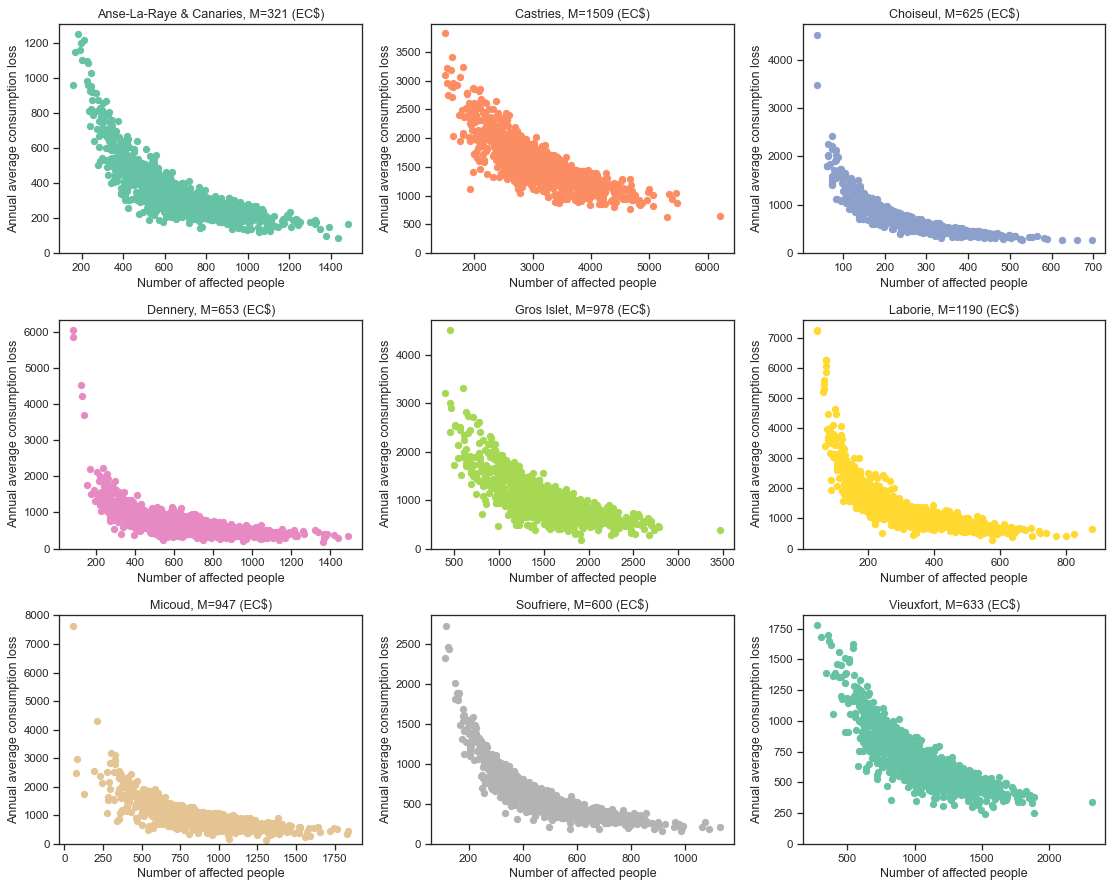

In [28]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 4 * n_districts / 3), sharex=False, sharey=False)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    x = df['n_affected_people']
    y = df['annual_average_consumption_loss']
    ax[i, j].scatter(x, y, color=color)
    ax[i, j].set_xlabel('Number of affected people')
    ax[i, j].set_ylabel('Annual average consumption loss')
    ax[i, j].set_ylim(0)
    ax[i, j].set_title(f'{district}, M={df["annual_average_consumption_loss"].median():.0f} (EC$)')

fig.tight_layout();

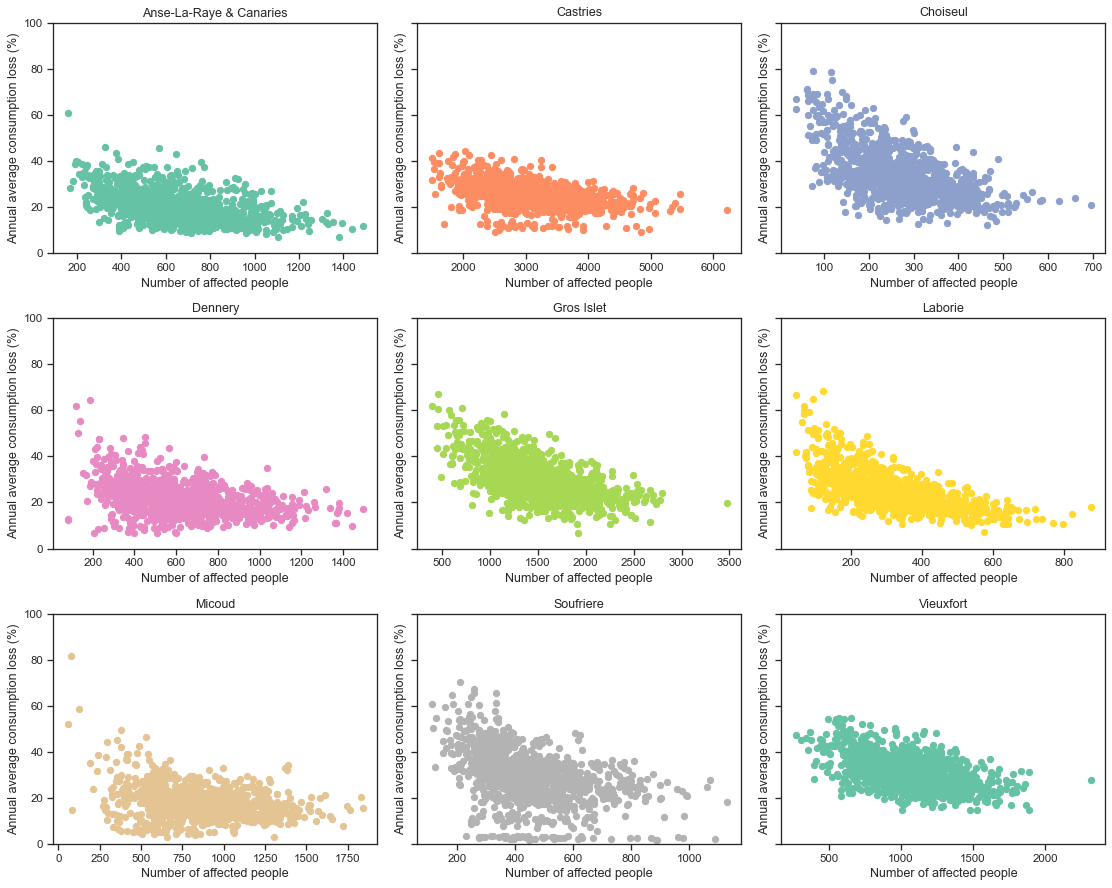

In [29]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 4 * n_districts / 3), sharex=False, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    x = df['n_affected_people']
    y = df['annual_average_consumption_loss_pct']
    ax[i, j].scatter(x, y, color=color)
    ax[i, j].set_xlabel('Number of affected people')
    ax[i, j].set_ylabel('Annual average consumption loss (%)')
    ax[i, j].set_ylim(0, 100)
    ax[i, j].set_title(district)

fig.tight_layout();

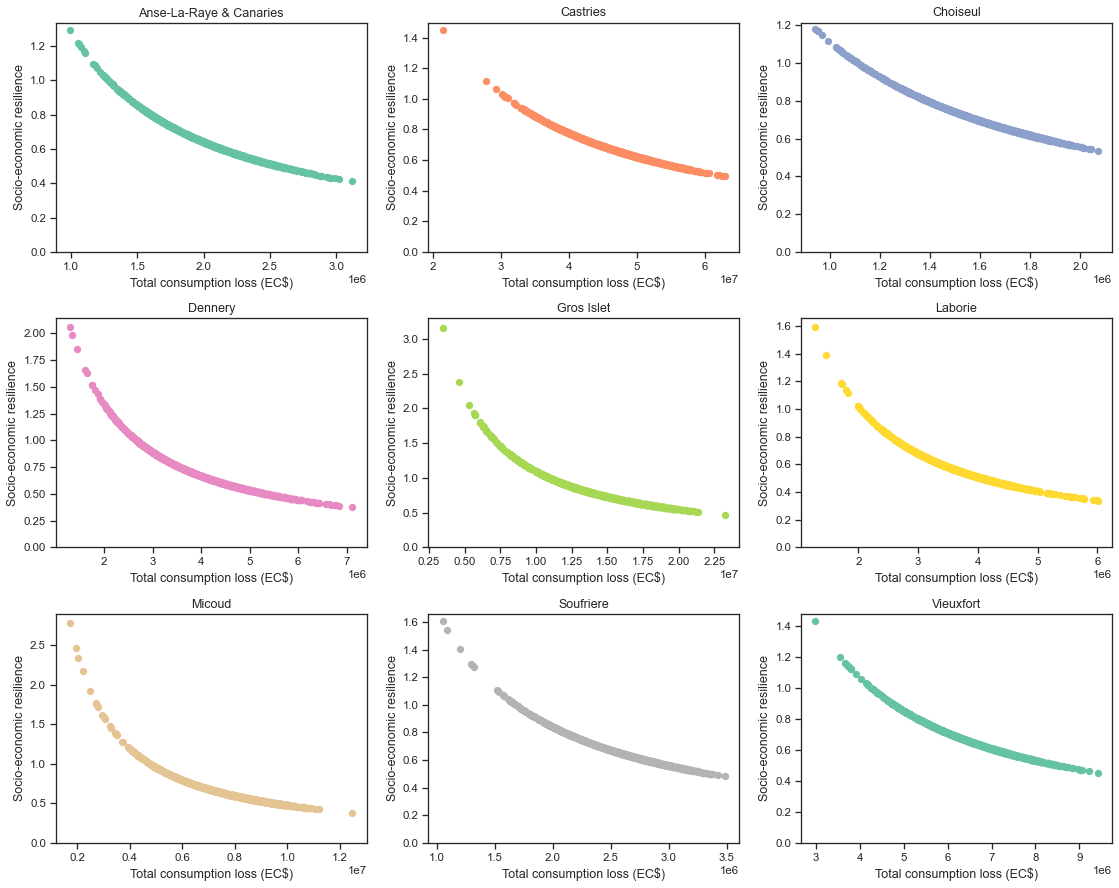

In [30]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 4 * n_districts / 3), sharex=False, sharey=False)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    x = df['total_consumption_loss']
    y = df['r']
    ax[i, j].scatter(x, y, color=color)
    ax[i, j].set_xlabel('Total consumption loss (EC$)')
    ax[i, j].set_ylabel('Socio-economic resilience')
    ax[i, j].set_ylim(0)
    ax[i, j].set_title(district)

fig.tight_layout();

## Examine consumption recovery 

In [7]:
districts = [
    'AnseLaRayeCanaries',
    'Castries',
    'Choiseul',
    'Dennery',
    'Gros Islet',
    'Laborie',
    'Micoud',
    'Soufriere',
    'Vieuxfort'
]

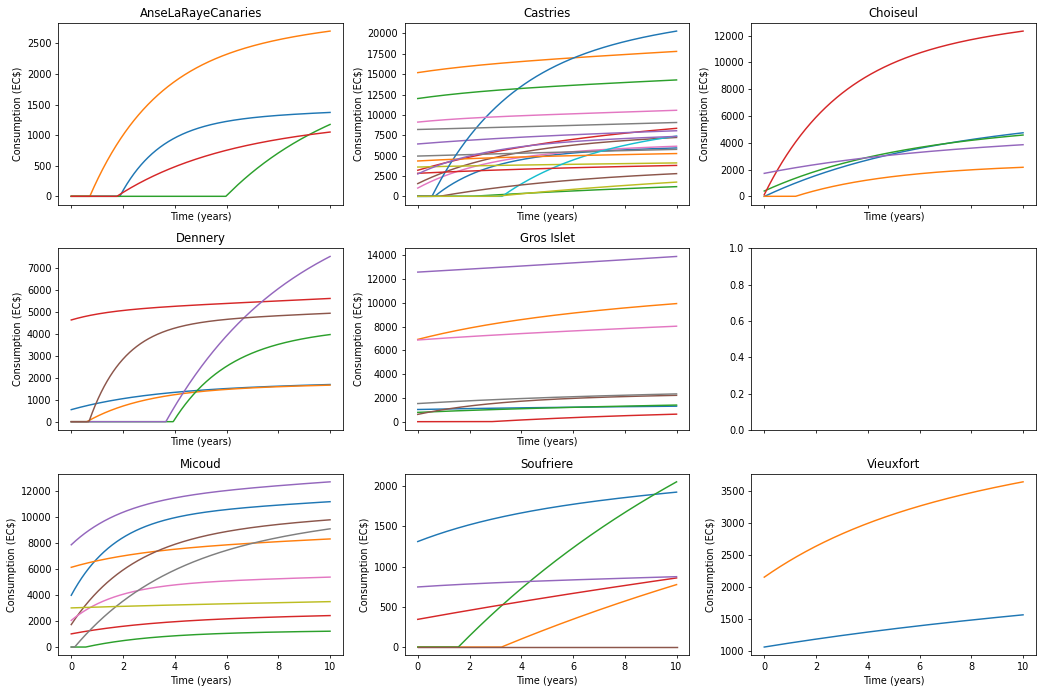

In [34]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(6 * 2.5, 4 * 2.5), sharey=False, sharex=True)

colors = sns.color_palette('Set1', len(districts))

for i, district in enumerate(districts):
    r = pkl.load(open(f'../src/{district}.pkl', 'rb'))
    n = r[0].shape[0]
    for j in range(n):
        x = []
        y = []
        for key, values in r.items():
            y.append(values[j])
            x.append(key)
        ax[i // 3, i % 3].plot(x, y)
        ax[i // 3, i % 3].set_xlabel('Time (years)')
        ax[i // 3, i % 3].set_ylabel('Consumption (EC$)')
        ax[i // 3, i % 3].set_title(f'{district}')
fig.tight_layout()

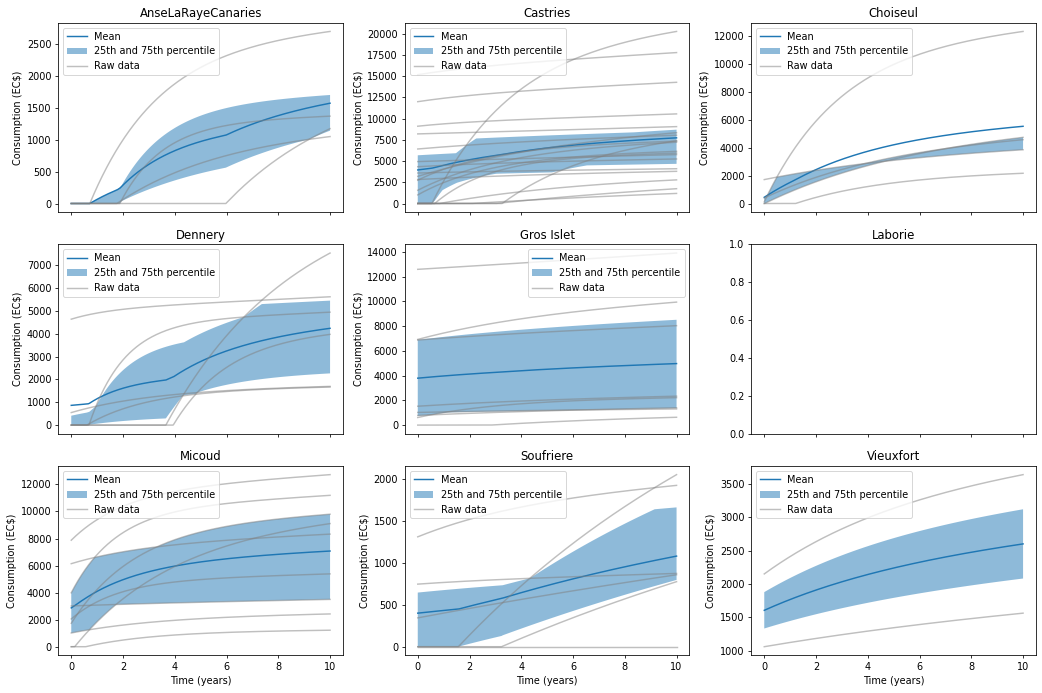

In [33]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(6 * 2.5, 4 * 2.5), sharey=False, sharex=True)

colors = sns.color_palette('Set1', len(districts))

for i, district in enumerate(districts):
    r = pkl.load(open(f'../src/{district}.pkl', 'rb'))
    n = r[0].shape[0]
    l = []
    if n == 0:
        ax[i // 3, i % 3].set_title(f'{district}')
        continue
    
    for j in range(n):
        x = []
        y = []
        for key, values in r.items():
            y.append(values[j])
            x.append(key)
        l.append(y)
    df = pd.DataFrame(l).T
    df.index = x
    q1 = df.quantile(0.25, axis=1)
    q3 = df.quantile(0.75, axis=1)
    ax[i // 3, i % 3].plot(x, df.mean(axis=1))
    ax[i // 3, i % 3].fill_between(x, q1, q3, alpha=0.5)
    df.plot(ax=ax[i // 3, i % 3], legend=False, color='gray', alpha=0.5)
    ax[i // 3, i % 3].set_xlabel('Time (years)')
    ax[i // 3, i % 3].set_ylabel('Consumption (EC$)')
    ax[i // 3, i % 3].set_title(f'{district}')
    ax[i // 3, i % 3].legend(['Mean', '25th and 75th percentile', 'Raw data'])
    
fig.tight_layout()

## Plot outcomes

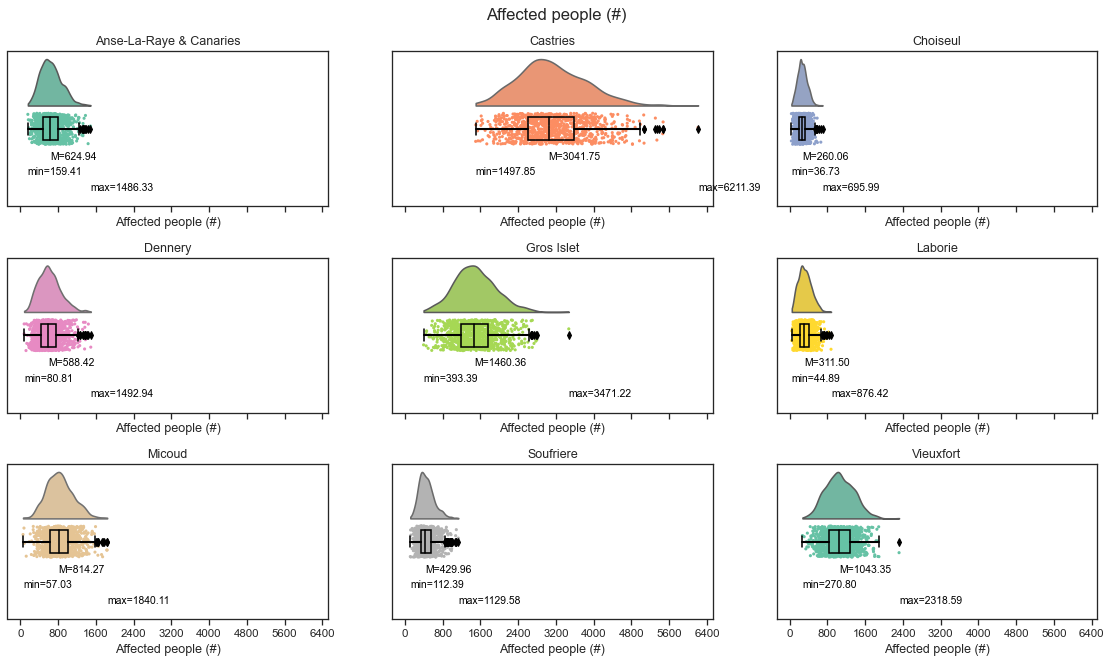

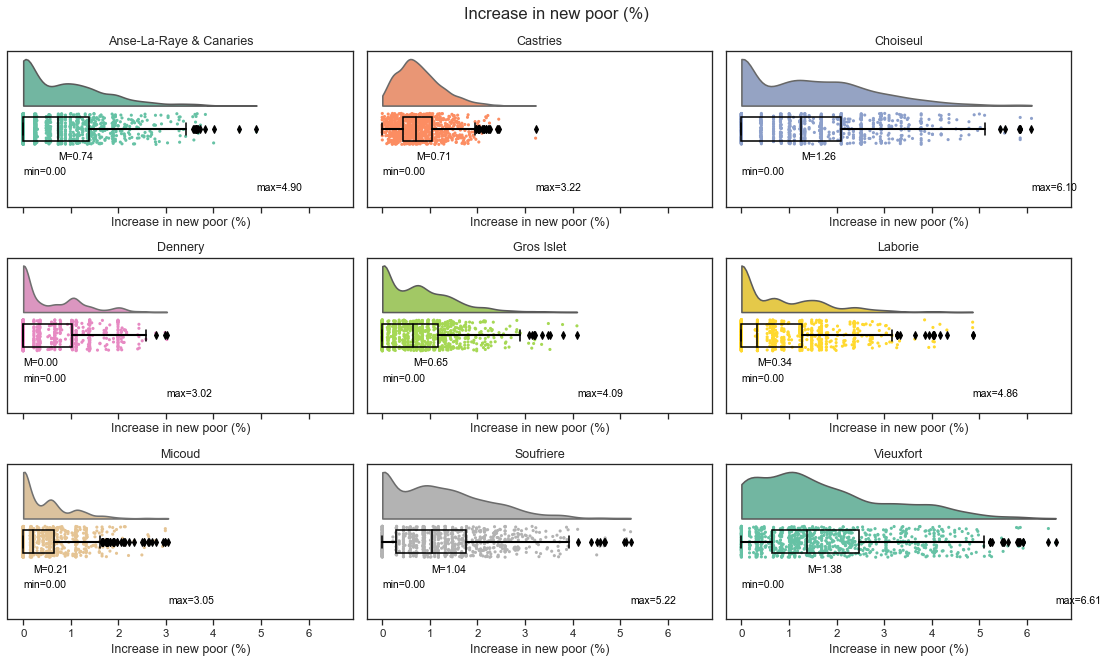

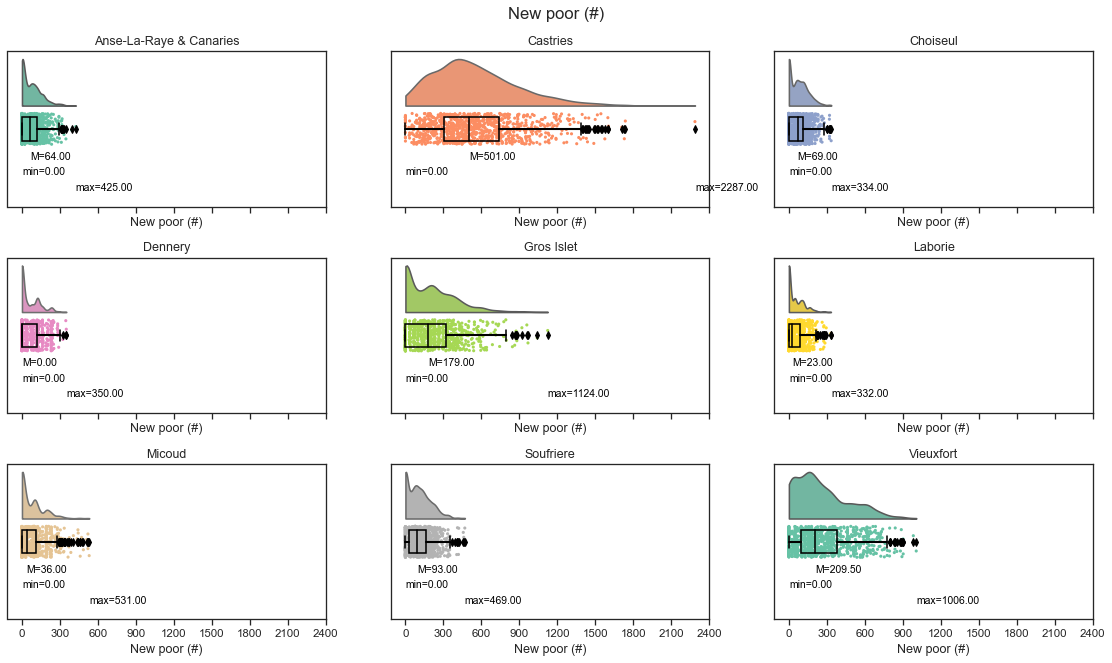

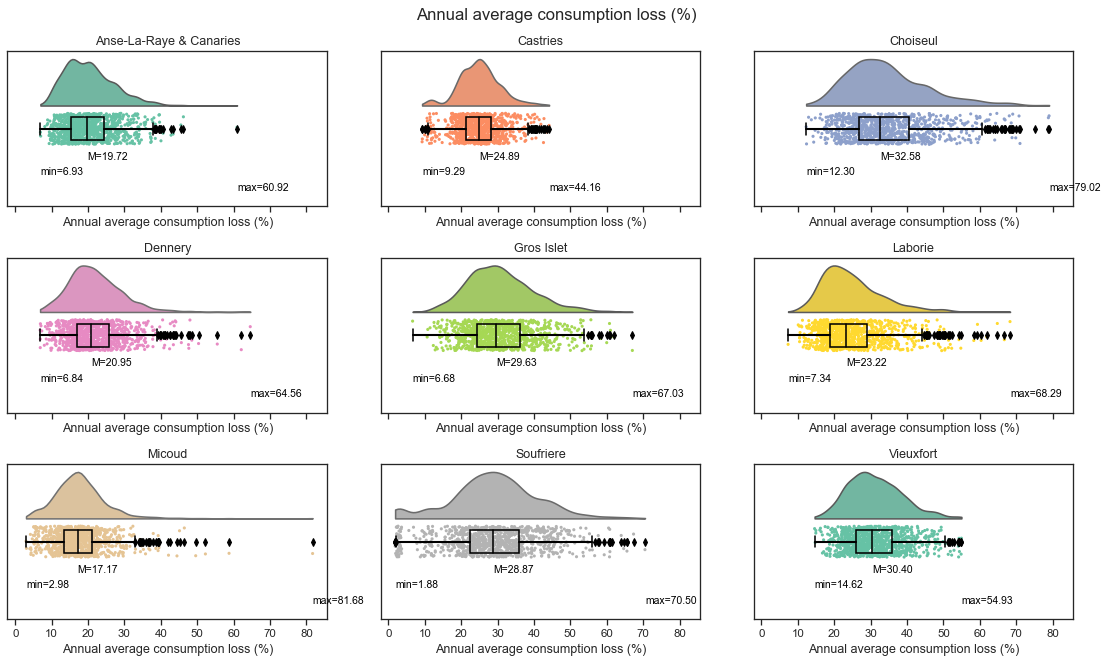

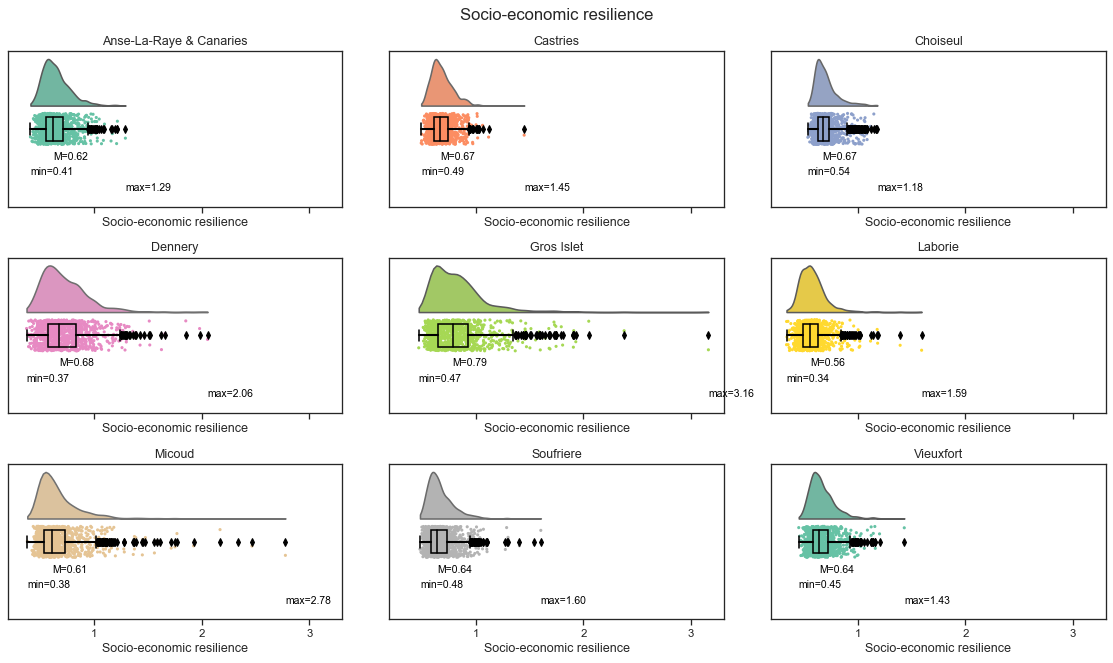

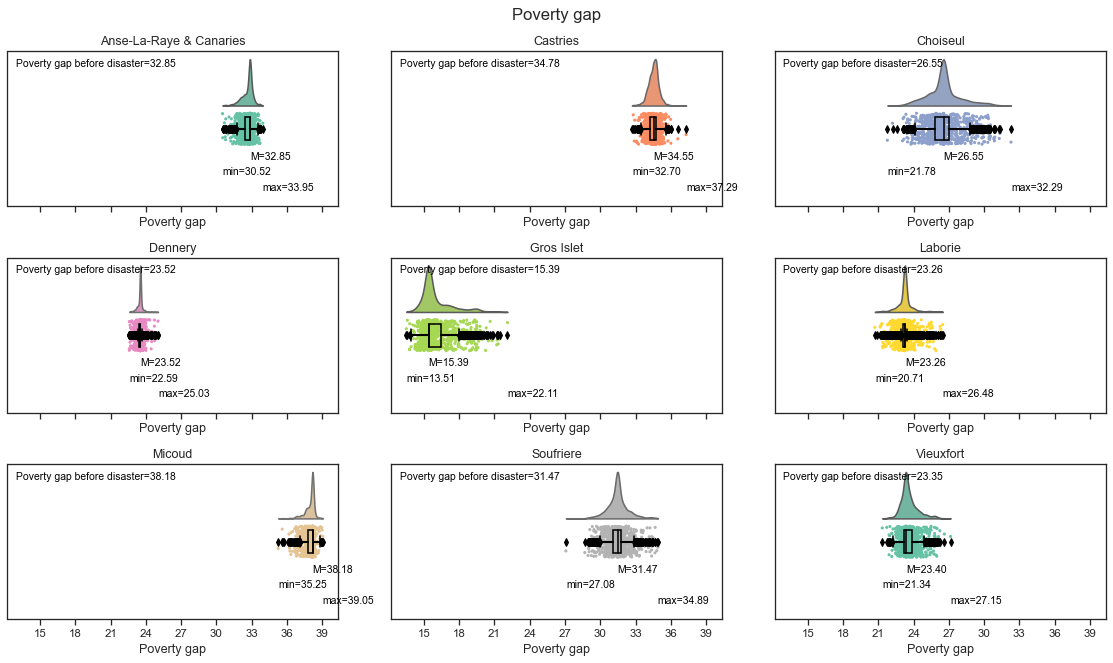

In [34]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
colors = sns.color_palette('Set2', n_colors=len(districts))

x_columns = [
    'n_affected_people',
    'n_new_poor_increase_pct', 
    'n_new_poor', 
    'annual_average_consumption_loss_pct', 
    'r',
    'new_poverty_gap',
    # 'one_year_in_poverty',
    # 'two_years_in_poverty',
    # 'three_years_in_poverty',
    # 'four_years_in_poverty',
    # 'five_years_in_poverty',
    # 'six_years_in_poverty',
    # 'seven_years_in_poverty',
    # 'eight_years_in_poverty',
    # 'nine_years_in_poverty',
    # 'ten_years_in_poverty'
    ]
x_titles = [
    'Affected people (#)',
    'Increase in new poor (%)', 
    'New poor (#)', 
    'Annual average consumption loss (%)', 
    'Socio-economic resilience',
    'Poverty gap',
    # 'One year in poverty',
    # 'Two years in poverty',
    # 'Three years in poverty',
    # 'Four years in poverty',
    # 'Five years in poverty',
    # 'Six years in poverty',
    # 'Seven years in poverty',
    # 'Eight years in poverty',
    # 'Nine years in poverty',
    # 'Ten years in poverty'
    ]

is_years_in_poverty = False

for x_column, x_title in zip(x_columns, x_titles):
    # if x_column == 'new_poor_increase_pct' or x_column == 'annual_average_consumption_loss_pct':
    #     sharex = True
    # else:
    #     sharex = False
    sharex = True
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True)

    for district in districts:
        df = outcomes[outcomes['district'] == district]
        
        # Calculate % increase in new poor in respect to the initial number of poor
        # df = df.assign(new_poor_increase_pct = df['new_poor'].div(df['poor_initial']).multiply(100))

        # Calculate an increase in new poor in respect to the total population
        df = df.assign(n_new_poor_increase_pct = df['n_new_poor'].div(df['total_population']).multiply(100))
        # df = df.assign(annual_average_consumption_loss_pct = df['annual_average_consumption_loss_pct'].multiply(100))
        # df = df.assign(one_year_in_poverty = df['years_in_poverty'].apply(lambda x: x[0]))
        # df = df.assign(two_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[1]))
        # df = df.assign(three_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[2]))
        # df = df.assign(four_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[3]))
        # df = df.assign(five_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[4]))
        # df = df.assign(six_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[5]))
        # df = df.assign(seven_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[6]))
        # df = df.assign(eight_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[7]))
        # df = df.assign(nine_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[8]))
        # df = df.assign(ten_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[9]))

        df[x_column] = df[x_column].astype(float)

        # Make a half violin plot
        pt.half_violinplot(x=x_column, 
                        y='policy', # hue='scenario',
                        data=df,
                        color=colors[districts.index(district)],
                        bw=.2, 
                        cut=0.,
                        scale="area", 
                        width=.6, 
                        inner=None,
                        ax=ax[districts.index(district) // 3, districts.index(district) % 3])
        
        # Add stripplot
        sns.stripplot(x=x_column,
                    y='policy', # hue='scenario',
                    data=df,
                    color=colors[districts.index(district)],
                    edgecolor='white',
                    size=3,
                    jitter=1,
                    zorder=0,
                    orient='h',
                    ax=ax[districts.index(district) // 3, districts.index(district) % 3])

        # Add boxplot
        sns.boxplot(x=x_column,
                    y='policy', # hue='scenario',
                    data=df,
                    color="black", 
                    width=.15, 
                    zorder=10,
                    showcaps=True, 
                    boxprops={'facecolor':'none', "zorder":10},
                    showfliers=True, 
                    whiskerprops={'linewidth':2, "zorder":10},
                    saturation=1, 
                    orient='h',
                    ax=ax[districts.index(district) // 3, districts.index(district) % 3])

        if district == 'AnseLaRayeCanaries':
            district_name = 'Anse-La-Raye & Canaries'
        else:
            district_name = district
        
        if is_years_in_poverty:
            title = district_name + ', E = ' + f'{round(df[x_column].mean())}'
        else:
            title = district_name
        ax[districts.index(district) // 3, districts.index(district) % 3].set_title(title)
        ax[districts.index(district) // 3, districts.index(district) % 3].set_ylabel('')
        ax[districts.index(district) // 3, districts.index(district) % 3].set_xlabel(x_title)

        # Remove x-axis labels
        ax[districts.index(district) // 3, districts.index(district) % 3].set_yticklabels([])
        # Remove y-axis ticks
        ax[districts.index(district) // 3, districts.index(district) % 3].set_yticks([])

        # Do not display floats in the x-axis
        ax[districts.index(district) // 3, districts.index(district) % 3].xaxis.set_major_locator(MaxNLocator(integer=True))

        # Plot the median
        # ax[districts.index(district) // 3, districts.index(district) % 3].axvline(df[x_column].median(), color='black', linestyle='--', linewidth=1)
        # Add text close to the boxplot's median
        ax[districts.index(district) // 3, districts.index(district) % 3].text(df[x_column].median(), 0.2, 
                                                                               f'M={df[x_column].median():.2f}', 
                                                                               horizontalalignment='left', size='small', color='black')
        
        # Add text close to the boxplot's min and max
        ax[districts.index(district) // 3, districts.index(district) % 3].text(df[x_column].min(), 0.3,
                                                                                 f'min={df[x_column].min():.2f}', 
                                                                                 horizontalalignment='left', size='small', color='black')
        ax[districts.index(district) // 3, districts.index(district) % 3].text(df[x_column].max(), 0.4,
                                                                                    f'max={df[x_column].max():.2f}', 
                                                                                    horizontalalignment='left', size='small', color='black')
        
        initial_poverty_gap = df['initial_poverty_gap'].iloc[0]
        # Add initial poverty gap as in the legend to the plot
        if x_column == 'new_poverty_gap':
            ax[districts.index(district) // 3, districts.index(district) % 3].text(0.025, 0.9,
                                                                                 f'Poverty gap before disaster={initial_poverty_gap:.2f}', 
                                                                                 horizontalalignment='left', size='small', color='black',
                                                                                 transform=ax[districts.index(district) // 3, districts.index(district) % 3].transAxes)
        

    # Add a super title
    fig.suptitle(x_title, fontsize=16)
    fig.tight_layout()
    # plt.savefig(f'../figures/analysis/{x_column}.png', dpi=300, bbox_inches='tight')

## Plot maps

In [7]:
# Load country shapefile
country = 'Saint Lucia'
gdf = gpd.read_file(f'../data/raw/shapefiles/{country}/gadm36_LCA_shp/gadm36_LCA_1.shp')

# Align district names with the ones in the outcomes
gdf['NAME_1'].replace({'Soufrière' : 'Soufriere', 'Vieux Fort' : 'Vieuxfort'}, inplace=True)

# Merge Anse-la-Raye and Canaries into a single geometry
geometry = gdf[gdf['NAME_1'].isin(['Anse-la-Raye', 'Canaries'])].unary_union

# Add it to the dataframe
gdf.loc[len(gdf)] = [None, None, 'LCA.11_1', 'Anse-La-Raye & Canaries', None, None, None, None, None, None, geometry]
gdf = gdf[gdf['NAME_1'].isin(outcomes['District'].unique())]

In [8]:
mean_outcomes = outcomes[['District'] + columns_of_interest].groupby('District').mean()
gdf = pd.merge(gdf, mean_outcomes, left_on='NAME_1', right_index=True)
gdf.reset_index(inplace=True)
gdf['id'] = gdf.index

In [9]:
gdf.to_file('saintlucia.json', driver='GeoJSON')